# Multiclass text classification

DMML - 2021 
Melinda Femminis, Catherine Pedroni, Estelle Valerie Tsague Mbialeu

**Detecting the difficulty level of french texts**

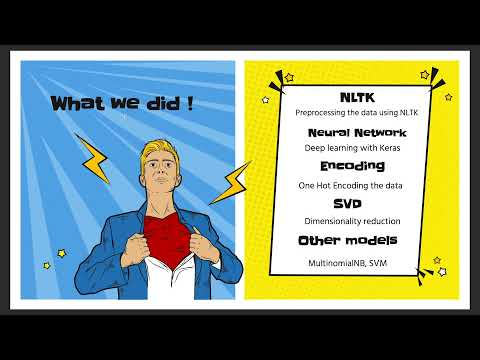

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('E2dCIjSSVVc')

# Imports

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
train_df = pd.read_csv('https://raw.githubusercontent.com/cpedroni/DMML2021_Microsoft/main/data/training_data.csv')
pred_df = pd.read_csv('https://raw.githubusercontent.com/cpedroni/DMML2021_Microsoft/main/data/unlabelled_test_data.csv')

NameError: ignored

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
import nltk as nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Exploratory data analysis

In [ ]:
# How many sentences of each category
train_df['difficulty'].value_counts()

A1    813
C2    807
C1    798
A2    795
B1    795
B2    792
Name: difficulty, dtype: int64

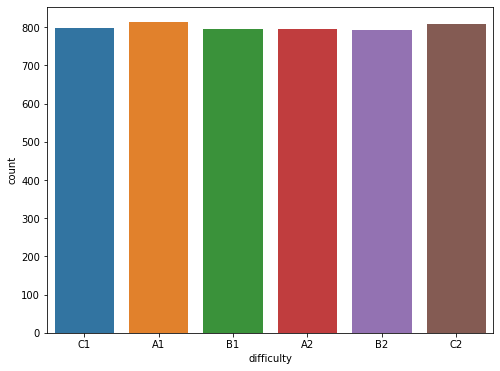

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x=train_df.difficulty)
plt.show()

In [ ]:
# Base rate
round(813 / len(train_df), 3)

0.169

# Metrics function

In [ ]:
def metrics(y_test, y_pred):
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  print("F1: " + str(2 * (precision * recall) / (precision + recall)))
  print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

# Base models: no preprocess, grid search

## Train test split

In [ ]:
X = train_df['sentence'] 
ylabels = train_df['difficulty'] 
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=0)

## Logistic Regression

In [ ]:
tfidf_params = dict(sublinear_tf= True, 
                       min_df = 1, 
                       norm= 'l2', 
                       ngram_range= (1,1),
                       lowercase=True,
                       tokenizer=word_tokenize)

clf_logreg = Pipeline(steps=[
  ('features', TfidfVectorizer(**tfidf_params)),
  ('model', LogisticRegression(random_state=0, solver='lbfgs', max_iter=300))
])

clf_logreg.fit(X_train, y_train)

y_pred_log = clf_logreg.predict(X_test)
metrics(y_test, y_pred_log)

Precision: 0.4815518348884597
Recall: 0.484451056383658
F1: 0.48299709498382265
Accuracy: 0.48333333333333334


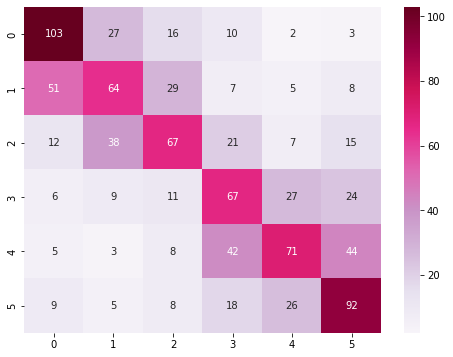

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_log)), annot=True, cmap='PuRd', fmt='.4g')

In [ ]:
# What sentences are missclassified ? 
test_sent = np.array(X_test)
test_array = np.array(y_test)
pred_array = np.array(y_pred_log)
wrong_predictions = list()
for i in range(0, 100):
  if pred_array[i] != test_array[i]:
     wrong_predictions.append([test_sent[i], test_array[i], pred_array[i]])
wrong_predictions[:10]

[["C'est en décembre 1967, après bien des invectives au Parlement, que sa loi relative à la régulation des naissances, dite loi Neuwirth est votée : elle autorise la vente exclusive des contraceptifs en pharmacie sur ordonnance médicale, avec autorisation parentale pour les mineures",
  'C1',
  'C2'],
 ['Giscard va pourtant réussir à transformer ce revers en tremplin',
  'C1',
  'A2'],
 ["Un choix difficile mais important : le public français écoute souvent les professionnels de Cannes pour choisir le film qu'il va aller voir au cinéma.",
  'A2',
  'B1'],
 ["Le débat porte plutôt sur l'utilité d'une telle mesure.", 'B1', 'B2'],
 ["Il faut du temps et du courage pour soigner toute cette ménagerie En plus des animaux, il faut aussi s'occuper du potager de mon papy",
  'A2',
  'B1'],
 ["Vous eussiez juré que les gens la voyaient, l'entendaient rouler pesamment devant eux, retentissante de tous les trésors enfermés dans ses flancs.",
  'C1',
  'C2'],
 ["Mon frère Patrice est plus jeune que

### This is the best model :predictions on pred_df and csv export

In [ ]:
preddf_log = clf.predict(pred_df["sentence"])
sample_submission = pred_df.drop(["sentence"], axis=1)
sample_submission["difficulty"] = preddf_log
sample_submission.head()
sample_submission.to_csv('sample_submission.csv', index=False)
!cp sample_submission.csv "drive/My Drive/"

## KNN

In [ ]:
tfidf_params = dict(sublinear_tf= True, 
                       min_df = 33, 
                       norm= 'l2', 
                       ngram_range= (1,1))

clf_knn = Pipeline(steps=[
  ('features', TfidfVectorizer(**tfidf_params)),
  ('model', KNeighborsClassifier(n_neighbors=30))
])
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
metrics(y_test, y_pred_knn)

Precision: 0.37199098400458047
Recall: 0.19011410356132766
F1: 0.25162815288924
Accuracy: 0.190625


In [ ]:
# Use gridsearch

tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=7, 
                        norm='l2', 
                        ngram_range=(1, 1))
X_train_norm = tfidf.fit_transform(X_train)
X_test_norm = tfidf.transform(X_test)

grid = {'n_neighbors':np.arange(1,100),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=5)
knn_cv.fit(X_train_norm, y_train)

# Print results
print("Hyperparameters:", knn_cv.best_params_)

Hyperparameters: {'n_neighbors': 67, 'p': 2, 'weights': 'distance'}
Train Score: 0.3797
Test Score: 0.401


In [ ]:
# Pipe with best param
clf_knn2 = Pipeline(steps=[
  ('features', TfidfVectorizer(**tfidf_params)),
  ('model', KNeighborsClassifier(n_neighbors=67, p=2, weights='distance'))
])

clf_knn2.fit(X_train, y_train)
y_pred_knn2 = clf_knn2.predict(X_test)
metrics(y_test, y_pred_knn2)

Precision: 0.4505571656860227
Recall: 0.2678352628253114
F1: 0.33595871030937335
Accuracy: 0.271875


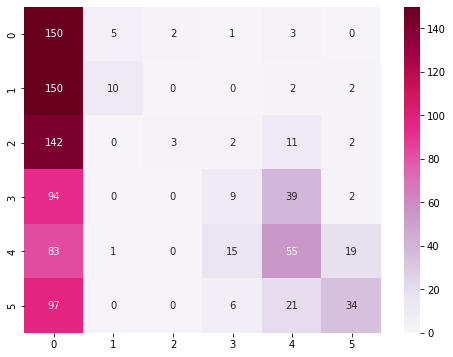

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_knn2)), annot=True, cmap='PuRd', fmt='.4g')

## Decision Tree

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 7),
                        min_df = 9, 
                        norm = 'l2',
                        lowercase=True,
                        tokenizer=word_tokenize,
                        analyzer='word'
                        )

clf_dt = Pipeline([('vectorizer', tfidf),
                 ('classifier', DecisionTreeClassifier(max_depth=1000))])

clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)
metrics(y_test, y_pred_dt)

Precision: 0.30272335211230655
Recall: 0.30316610968967683
F1: 0.302944569127034
Accuracy: 0.303125


In [ ]:
# Grid search

grid = {'criterion':['gini','entropy'],
             'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

classifier = DecisionTreeClassifier()
classifier_cv = GridSearchCV(classifier,grid,cv=5)

clf_dt2 = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier_cv)])

clf_dt2.fit(X_train, y_train)
y_pred_dt2 = clf_dt2.predict(X_test)
metrics(y_test, y_pred_dt2)

Precision: 0.3047285925891155
Recall: 0.3040705168276593
F1: 0.3043991990379362
Accuracy: 0.30625


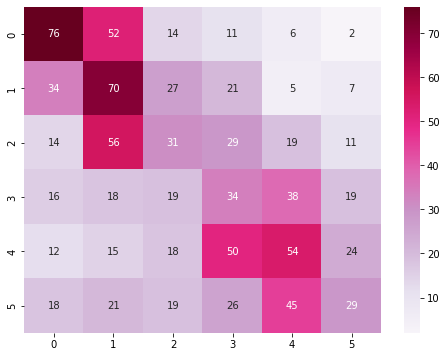

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_dt2)), annot=True, cmap='PuRd', fmt='.4g')

## Random forest

In [ ]:
tfidf_params = dict(sublinear_tf= True, 
                       min_df = 4, 
                       norm= 'l2', 
                       ngram_range= (1,7),
                       tokenizer= word_tokenize)

classifier = RandomForestClassifier(n_estimators=500)

rdf = Pipeline(steps=[
  ('features', TfidfVectorizer(**tfidf_params)),
  ('model', classifier)
])

rdf.fit(X_train, y_train)
y_pred_rf = rdf.predict(X_test)
metrics(y_test, y_pred_rf)

Precision: 0.4395977664429535
Recall: 0.43435429431197264
F1: 0.43696030068173775
Accuracy: 0.4322916666666667


In [ ]:
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rdf2 = Pipeline(steps=[
  ('features', TfidfVectorizer(**tfidf_params)),
  ('model', GridSearchCV(estimator=classifier, param_grid=param_grid, cv= 5))
])

rdf2.fit(X_train, y_train)
y_pred_rdf2 = rdf2.predict(X_test)
metrics(y_test, y_pred_rdf2)

Precision: 0.38372919578427855
Recall: 0.3732339405893779
F1: 0.37840881009841343
Accuracy: 0.371875


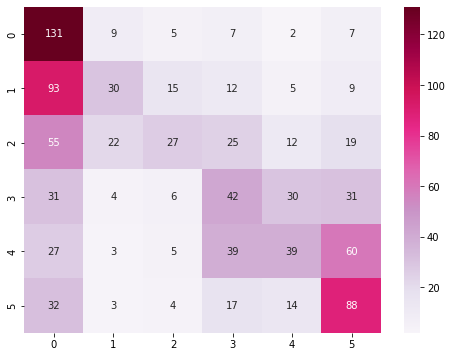

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_rdf2)), annot=True, cmap='PuRd', fmt='.4g')

# What we did to improve those models

## Preprocess

- remove punctuation
- remove stopwords
- remove X most/least frequent words
- stemming


In [ ]:
# Set to lowercase
train_df['sentence'] = train_df['sentence'].str.lower()

In [ ]:
#Replace ' with a space so we can separate c'est, m'y, n'étant etc...
train_df = train_df.replace("'", " ", regex=True)
train_df = train_df.replace("-", " ", regex=True)

#Remove punctuation
PUNCT = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT))
train_df['sentence'] = train_df['sentence'].apply(lambda text: remove_punctuation(text))

In [ ]:
# Get stopwords list
nltk.download('stopwords')
", ".join(stopwords.words('french'))
stop = stopwords.words('french')

In [ ]:
# Remove stopwords
train_df['sentence'] = train_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
from collections import Counter
cnt = Counter()
for text in train_df["sentence"].values:
    for word in text.split():
        cnt[word] += 1 
cnt.most_common(10)

In [ ]:
# Create new column without X frequent words
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
train_df["sent_10frequentwords"] = train_df["sentence"].apply(lambda text: remove_freqwords(text))

In [ ]:
# Similarly we can remove X rare words 
rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
   return " ".join([word for word in str(text).split() if word not in RAREWORDS])
train_df['sent_10rarewords'] = train_df['sentence'].apply(lambda text: remove_rarewords(text))


In [ ]:
from nltk import word_tokenize
nltk.download('punkt')

train_df['sent_token'] = train_df['sentence'].apply(lambda X: word_tokenize(X))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()
train_df['sent_stemmed'] = train_df['sent_token'].apply(lambda x: [stemmer.stem(y) for y in x])

In [ ]:
# REMOVE NUMBERS from the new list of stemmed token. We should also try with sent_token (not stemmed)
col = 'sent_stemmed'
train_df[col] = (
    train_df[col]
    .explode()
    .str.replace("\d+", "NUM", regex=True)
    .groupby(level=0)
    .agg(list)
)

## One-hot encoding of the label variable

In [ ]:
train_df['difficulty'] = [0 if x=='A1' 
                   else 1 if x=='A2'
                   else 2 if x=='B1'
                   else 3 if x=='B2'
                   else 4 if x=='C1'
                   else 5 for x in train_df.difficulty]
train_df['difficulty'].value_counts()

## Dimentionality reduction (SVD)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

X = train_df.sentence
y = train_df.difficulty
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=900, random_state=0)

In [ ]:
# Truncated SVD with CountVectorizer + MaxAbsScaler()

pipe = Pipeline([('svd', svd), 
                 ('logistic', LogisticRegression(random_state=0, 
                                                 solver='lbfgs', 
                                                 max_iter=300))])

pipe.fit(X_train_rescaled, y_train)
y_pred_pca = pipe.predict(X_test_rescaled)
metrics(y_test, y_pred_pca)

Precision: 0.43595794084222256
Recall: 0.4349100758653337
F1: 0.43543337793620124
Accuracy: 0.43333333333333335


In [ ]:
# Truncated SVD with TF-IDF
tfidf_params = dict(sublinear_tf= True, 
                       min_df = 1, 
                       norm= 'l2', 
                       ngram_range= (1,1),
                       lowercase=True,
                       tokenizer=word_tokenize)

clf_logreg_svd = Pipeline(steps=[
  ('features', TfidfVectorizer(**tfidf_params)),
  ('svd', svd),
  ('model', LogisticRegression(random_state=0, solver='lbfgs', max_iter=300))
])

clf_logreg_svd.fit(X_train, y_train)

y_pred_log_svd = clf_logreg_svd.predict(X_test)
metrics(y_test, y_pred_log_svd)

Precision: 0.4781840924118071
Recall: 0.48100479763079035
F1: 0.4795902975702518
Accuracy: 0.48020833333333335


## MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

tfidf_params = dict(sublinear_tf= True, 
                       min_df = 4, 
                       norm= 'l2', 
                       ngram_range= (1,4),
                       tokenizer= word_tokenize)
nb1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

nb2 = Pipeline([
    ('vect', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB()),
])

nb1.fit(X_train, y_train)
y_pred_nb1 = nb1.predict(X_test)
metrics(y_test, y_pred_nb1)

Precision: 0.4735956170503406
Recall: 0.4291585435934539
F1: 0.45028339746586665
Accuracy: 0.42916666666666664


In [ ]:
nb2.fit(X_train, y_train)
y_pred_nb2 = nb2.predict(X_test)
metrics(y_test, y_pred_nb2)

Precision: 0.4522194651013634
Recall: 0.44899070753366016
F1: 0.4505993024971846
Accuracy: 0.4479166666666667


## Support Vector Machine

In [ ]:
from sklearn import svm

tfidf_params = dict(sublinear_tf= True, 
                       min_df = 4, 
                       norm= 'l2', 
                       ngram_range= (1,4),
                       tokenizer= word_tokenize)
svm1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', svm.SVC()),
])

svm2 = Pipeline([
    ('vect', TfidfVectorizer(**tfidf_params)),
    ('clf', svm.SVC()),
])

svm1.fit(X_train, y_train)
y_pred_svm1 = svm1.predict(X_test)
metrics(y_test, y_pred_svm1)

Precision: 0.4257894797455522
Recall: 0.4243528418541098
F1: 0.42506994692753064
Accuracy: 0.42083333333333334


In [ ]:
svm2.fit(X_train, y_train)
y_pred_svm2 = svm2.predict(X_test)
metrics(y_test, y_pred_svm2)

Precision: 0.47610956920464237
Recall: 0.4730529936455696
F1: 0.4745763599003251
Accuracy: 0.471875


## Deep learning: neural networks with Keras 
See separate notebook.


